## Lasso Problem

The classic lasso problem is:
$$
\underset{x}{\min} \quad \frac12 \|Ax - b\|^2 + \lambda \|x\|_1
$$
where $\|x\|_1 = \sum_{i=1}^n |x_i|$.

JuMP requires that all functions are differentiable (the absolute value is not differentiable at 0). Therefore, we solve this problem using the epigraph trick by introducing variables $y_1, \dots, y_n$:

\begin{align*}
\underset{x,y}{\min} \quad &\frac12 \|Ax - b\|^2 + \lambda \sum_{i=1}^n y_i \\
\text{s.t.} \quad \ \ &y_i \geq x_i \ \forall i=1,\dots,n \\
&y_i \geq -x_i \ \forall i=1,\dots,n
\end{align*}

In [4]:
using JuMP
using Ipopt
using Random, Distributions
using LinearAlgebra

#Make sure notebook always produces the same results
Random.seed!(0)

n=100;
m=1000;

numsamples = m;

#Create a multivariate normal distribution with zero mean
#and the identity matrix for the covariance
mu = zeros(m)
d = MvNormal(mu, 25*Diagonal(ones(m)))

#Generate a random vector using uniformly at random noise,
#just going to be used to select some indices which will
#be non-zero in our "ground truth" vector
v = rand(Uniform(0,1), 100)
#Find the 10 indices with the largest values in v
nonzeros = partialsortperm(v, 1:10)

#Create a vector of 0's
groundtruth = zeros(n)
#For the indices that will be non-zero, give them a random value
for i=1:length(nonzeros)
    groundtruth[nonzeros[i]] = rand(Normal(0,0.75))
end

#Create a random matrix using the matrix normal distribution
A = rand(MatrixNormal(zeros(m,n), Diagonal(ones(m,m)), Diagonal(ones(n,n))))

#Set the RHS vector be to be A*groundtruth + noise
#(coming from the distribution d) defined above
b = A*groundtruth + rand(d)

#Run this with no regularization, regularization parameter of 100 and
#regularization parameter of 200
lambdas = [0, 100, 200]

xout = zeros(n,length(lambdas))

i = 1
#Run this loop once per regularization parameter λ
#Store the result in a column of xout
for λ in lambdas
    lasso = Model(Ipopt.Optimizer)
    @variable(lasso, x[1:n])
    #Add epigraph variables
    @variable(lasso, y[1:n] >= 0)

    #Add epigraph constraints for the absolute value of x
    @constraint(lasso, epigraph1[i in 1:n], y[i] >= x[i])
    @constraint(lasso, epigraph2[i in 1:n], y[i] >= -x[i])

    #Objective is least squares + λ*\|x\|_1 (which is handled by the epigraph constraints)
    @objective(lasso, Min, (1/2)*(A*x - b)'*(A*x - b) + λ*sum(y[i] for i in 1:n))

    optimize!(lasso);
    xout[:,i] = value.(x)
    i = i+1
end

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      200
                     variables with only lower bounds:      100
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4270146e+04 0.00e+00 3.43e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

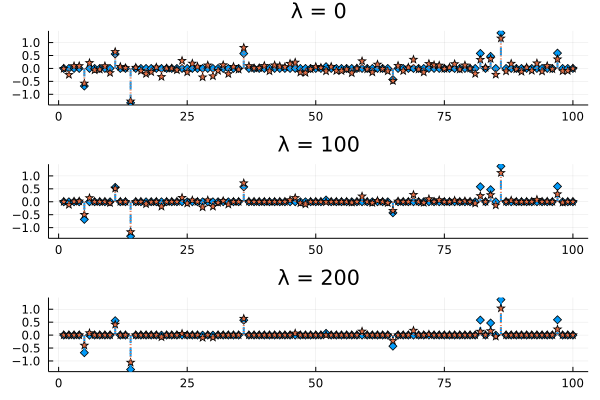

In [5]:
xaxis = 1:n
using Plots

#Plot the results for different values of λ
#Blue diamonds are the "ground truth", red stars are the solution for that lambda parameter
plot1 = plot(xaxis, groundtruth, seriestype = :sticks,markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = 0")
plot1 = plot!(xaxis, xout[:,1], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot)

plot2 = plot(xaxis, groundtruth, seriestype = :sticks,markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = 100")
plot2 = plot!(xaxis, xout[:,2], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot)

plot3 = plot(xaxis, groundtruth, seriestype = :sticks,markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = 200")
plot3 = plot!(xaxis, xout[:,3], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot)

plot(plot1, plot2, plot3, layout = (3, 1), legend = false)